In [523]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
import ForwardDiff as FD

  Activating environment at `~/SSD/Code/TinyMPC/julia/cone_simple/Project.toml`


In [534]:
n = 4; m = 2; N = 5;
inds = reshape(1:(n+m)*N,n+m,N)
xinds = [z[1:n] for z in eachcol(inds)]
uinds = [z[n+1:end] for z in eachcol(inds)][1:N-1]

4-element Vector{Vector{Int64}}:
 [5, 6]
 [11, 12]
 [17, 18]
 [23, 24]

In [567]:
# -------------------THIS IS ALL ALTRO-------------------------------
# This enables goal equality constraints, state and input ineq constraints.

function stage_cost(p::NamedTuple,x,u,k)
    dx = x - p.Xref[k]
    du = u - p.Uref[k]
    return 0.5*dx'*p.Q*dx + 0.5*du'*p.R*du
end
function term_cost(p::NamedTuple,x)
    dx = x - p.Xref[p.N]
    return 0.5*dx'*p.Qf*dx
end
function stage_cost_expansion(p::NamedTuple,k)
    dx = - p.Xref[k]
    du = - p.Uref[k]
    return p.Q, p.Q*dx, p.R, p.R*du  # Hessian and gradient
end
function term_cost_expansion(p::NamedTuple)
    dx = - p.Xref[p.N]
    return p.Qf, p.Qf*dx
end
function conic_cost_expansion(p::NamedTuple, u, λc, ρ, k)
    λhat = λc # already updated
    ∇c = cone_u_jac(p, u)
    G = ∇c'*∇projection(λhat)*projection(λhat)
    H = ∇c'*∇projection(λhat)'*∇projection(λhat)*∇c/ρ
    # display(∇projection(λhat)')
    # H = zeros(p.ncu_cone,p.ncu_cone)
    return (G - H*u), H
end
function backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
    """iLQR backward pass with AL. This !function update its parameters
    """
    N = params.N
    ΔJ = 0.0    # expected cost reduction

    # terminal cost expansion
    P[N], p[N] = term_cost_expansion(params) 
    
    if (params.ncx > 0)
        # # add AL terms for the state constraint at the final time step
        hxv = ineq_con_x(params,X[N])  # h(x) violation  
        mask = eval_mask(μx[N],hxv)
        ∇hx = ineq_con_x_jac(params,X[N])
        # add these into the cost-to-go p and P
        p[N]  += ∇hx'*(μx[N] - ρ*(mask * [params.x_max;-params.x_min]))  # multiplier term (1st)
        P[N]  += ρ*∇hx'*mask*∇hx                # penalty term (2nd)
    end
    
    if (params.ncg > 0)
        # add AL terms for goal constraint 
        ∇hx = diagm(ones(params.nx))
        # add these into the CTG p and P (equality active)
        p[N]  += ∇hx'*(λ - ρ*params.Xref[N])   
        P[N]  += ρ*∇hx'∇hx
    end
    
    # iterate from N-1 to 1 backwards
    for k = (N-1):(-1):1
        # dynamics jacobians (linearization about previous iterate)
        A = FD.jacobian(_x -> discrete_dynamics(params,_x,U[k],k),X[k])
        B = FD.jacobian(_u -> discrete_dynamics(params,X[k],_u,k),U[k])

        Sxx,Sx,Suu,Su = stage_cost_expansion(params,k)
        
        # one-step cost expansion: Q, Q*dx, R, R*du
        Sx += A' * (P[k+1]*f + p[k+1]) 
        Su += B' * (P[k+1]*f + p[k+1]) 
        Sxx += A'*(P[k+1])*A
        Suu += B'*(P[k+1] + reg*I)*B                                     
        Sux = B'*(P[k+1])*A  
        if (params.ncu > 0)
            # control constraints
            huv = ineq_con_u(params,U[k])  # calculate h(u) constraint
            mask = eval_mask(μ[k],huv)  # choose active
            ∇hu = ineq_con_u_jac(params,U[k])
            Su  += ∇hu'*(μ[k] - ρ*(mask * [params.u_max;-params.u_min])) # add to cost
            Suu += ρ*∇hu'*mask*∇hu
        end
        if (params.ncx > 0)
            # state constraints
            hxv = ineq_con_x(params,X[k])
            mask = eval_mask(μx[k],hxv)
            ∇hx = ineq_con_x_jac(params,X[k])
            Sx  += ∇hx'*(μx[k] - ρ*(mask * [params.x_max;-params.x_min]))
            Sxx += ρ*∇hx'*mask*∇hx
        end
        if (params.ncu_cone > 0)
            # conic constraints
            Qu, Quu = conic_cost_expansion(params, U[k], λc[k], ρ/cone_scale, k)
            # display(Quu)
            Su += Qu
            Suu += Quu
        end
        
        # Calculate Gains
        F = cholesky(Symmetric(Suu))
        d[k] = F\Su
        K[k] = F\Sux

        # Cost-to-go Recurrence (PSD stabilizing version, last term)
        P[k] = Sxx + K[k]'*Suu*K[k] - 2*K[k]'*Sux
        p[k] = Sx + K[k]'*Suu*d[k] - K[k]'*Su - Sux'*d[k]
        ΔJ += Su'*d[k]
    end

    return ΔJ  # but also change params
end
function forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ; 
                        max_linesearch_iters = 20)
    """iLQR forward pass and line-search
    This !function update its parameters
    """
    N = params.N
        # Forward Rollout
        for k = 1:(N-1)
            Un[k] = - d[k] - K[k]*Xn[k] 
            Xn[k+1] = discrete_dynamics(params,Xn[k],Un[k],k)
        end
    X .= Xn
    U .= Un
    return 0, 0
end
function eval_mask(μv,huv)  
    # Extract active inequality constraints
    # active set mask
    mask = Diagonal(zeros(length(huv)))
    for i = 1:length(huv)
        mask[i,i] = (μv[i] > 0 || huv[i] > 0)
    end
    mask
end
function mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-3,max_iters = 250,verbose = true,ρ=1,ϕ=10)

    # first check the sizes of everything
    # @assert length(X) == params.N
    # @assert length(U) == params.N-1
    # @assert length(X[1]) == params.nx
    # @assert length(U[1]) == params.nu

    # keep track of trajectories for each iterate
    Xh=[deepcopy(X) for i = 1:1000]

    # initial rollout
    N = params.N
    for i = 1:N-1
        X[i+1] = discrete_dynamics(params,X[i],U[i],i)
    end

    Xh[1] .= X

    reg_min = 1e-8
    reg = reg_min

    μ = [zeros(params.ncu) for i = 1:N-1]   # input constraints

    μx = [zeros(params.ncx) for i = 1:N]    # state constraints

    λ = zeros(params.nx)    # goal constraint

    λc = [zeros(params.ncu_cone) for i = 1:N-1]   # goal constraint
    
    # Inner loop to solve unconstrained problem (Riccati)
    for iter = 1:max_iters
        J = 0.0
        ΔJ = 0.0
        α = 1.0
        for i = 1:5
            ΔJ = backward_pass!(params,X,U,P,p,d,K,reg,μ,μx,ρ,λ,λc)
            J, α = forward_pass!(params,X,U,K,d,ΔJ,Xn,Un,μ,μx,ρ,λ)
        end

        Xh[iter + 1] .= X  
        if verbose
            if rem(iter-1,10)==0
                @printf "iter     J           ΔJ        |d|         α        reg         ρ\n"
                @printf "---------------------------------------------------------------------\n"
            end
            @printf("%3d   %10.3e  %9.2e  %9.2e  %6.4f   %9.2e   %9.2e\n",
              iter, J, ΔJ, 0, α, reg, ρ)
        end
        # update multipliers and check constraint violation, max of all
        convio = 0  
        
        if (params.ncu > 0)
            # control constraints (inequality)
            for k = 1:N-1
                huv = ineq_con_u(params,U[k])
                mask = eval_mask(μ[k],huv)
                # update dual
                convio = max(convio,norm(huv + abs.(huv),Inf))
                μ[k] = max.(0,μ[k] - ρ*(mask * [params.u_max;-params.u_min]))
                
            end
        end
        if (params.ncx > 0)
            # state constraints (inequality)
            for k = 1:N
                hxv = ineq_con_x(params,X[k])
                mask = eval_mask(μx[k],hxv)
                # update dual
                convio = max(convio,norm(hxv + abs.(hxv),Inf))
                μx[k] = max.(0,μx[k] - ρ*(mask * [params.x_max;-params.x_min]))                
            end
        end
        if (params.ncu_cone > 0)
            # conic constraints 
            if verbose
                print("update cone\n")
            end            
            for k = 1:N-1
                # update dual
                Uc = cone_u(params, U[k])
                huc = norm(Uc[1:2]) - Uc[3]
                convio = max(convio, norm(huc + abs.(huc),Inf))
                λc[k] = projection(λc[k] + Uc/cone_scale/ρ)
                # display(λc[k])
            end
        end
        if (params.ncg > 0)
            # goal constraint (equality)
            hxv = X[N] - params.Xref[N]
            λ .-= ρ*params.Xref[N]
            convio = max(convio, norm(hxv,Inf))
        end
        if verbose
            @show convio
        end
        if convio <1e-4  # if terminal condition with contraint violation
            # @info "success!"
            return Xh[1:(iter + 1)];
        end

        ρ *= ϕ  # update penalty
    end
end
#----------------------ALTRO DONE --------------------------

mpc (generic function with 1 method)

In [526]:
# =============================
# Example problem formulation and solve
# =============================

# ---------------------THIS IS WHAT YOU NEED TO INPUT--------
A = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
B = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
function discrete_dynamics(p::NamedTuple,x,u,k)
    A = [1.0 0.0 0.0 0.05 0.0 0.0; 
        0.0 1.0 0.0 0.0 0.05 0.0; 
        0.0 0.0 1.0 0.0 0.0 0.05; 
        0.0 0.0 0.0 1.0 0.0 0.0; 
        0.0 0.0 0.0 0.0 1.0 0.0; 
        0.0 0.0 0.0 0.0 0.0 1.0]
    B = [0.000125 0.0 0.0; 
        0.0 0.000125 0.0;
        0.0 0.0 0.000125; 
        0.005 0.0 0.0; 
        0.0 0.005 0.0; 
        0.0 0.0 0.005]
    f = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905]
    return A*x + B*u + f
end
function ineq_con_x(p,x)
    [x-p.x_max;-x + p.x_min]
end
function ineq_con_u(p,u)
    [u-p.u_max;-u + p.u_min]
end
function cone_u(p, u)
    [p.A_cone*u;p.c_cone'*u]
end
function cone_u_jac(p, u)
    J = zeros(p.nu, p.nu)
    J[1:end-1,1:end] .= p.A_cone
    J[end,1:end] .= p.c_cone
    return J
end
function ineq_con_u_jac(params,u)
    FD.jacobian(_u -> ineq_con_u(params,_u), u)
end
function ineq_con_x_jac(p,x)
    FD.jacobian(_x -> ineq_con_x(p,_x),x)
end
function projection(x)
    n = length(x)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s  # below the cone
        return zero(x)
    elseif a <= s  # in the code
        return x
    elseif a >= abs(s)  # outside the cone
        return 0.5 * (1 + s/a) * [v; a] 
    end
end
function ∇projection(x)
    n = length(x)
    J = zeros(eltype(x),n,n)
    s = x[end]
    v = view(x,1:n-1)
    a = norm(v)
    if a <= -s
        return J  # zeros
    elseif a <= s
        J .= I(n)  
        return J  # identity
    elseif a >= abs(s)
        c = 0.5 * (1 + s/a)

        # dvdv ok!
        for i = 1:n-1, j = 1:n-1
            J[i,j] = -0.5*s/a^3 * v[i] * v[j]
            if i == j
                J[i,j] += c
            end
        end

        # dvds ok!
        for i = 1:n-1
            J[i,n] = 0.5 * v[i] / a
        end

        # dsdv ok!
        for i = 1:n-1
            J[n,i] = ((-0.5*s/a^2) + c/a) * v[i]
        end
        J[n,n] = 0.5  # ok
        return J
    else
        error("Invalid second-order cone projection.")
    end
    return J
end

∇projection (generic function with 1 method)

iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    0.000e+00   5.46e+05   0.00e+00  0.0000    1.00e-08    1.00e+00
update cone
convio = 468.5707782428367
  2    0.000e+00   1.80e+06   0.00e+00  0.0000    1.00e-08    1.00e+01
update cone
convio = 153.63477751097642
  3    0.000e+00   3.67e+06   0.00e+00  0.0000    1.00e-08    1.00e+02
update cone
convio = 31.691342916888306
  4    0.000e+00   3.81e+06   0.00e+00  0.0000    1.00e-08    1.00e+03
update cone
convio = 12.584890723426893
  5    0.000e+00   3.20e+06   0.00e+00  0.0000    1.00e-08    1.00e+04
update cone
convio = 1.8356554300783683
  6    0.000e+00   3.08e+06   0.00e+00  0.0000    1.00e-08    1.00e+05
update cone
convio = 0.19244467888096328
  7    0.000e+00   3.30e+06   0.00e+00  0.0000    1.00e-08    1.00e+06
update cone
convio = 0.019338063499303892
  8    0.000e+00   5.51e+06   0.00e+00  0.0000    1.00e-08    1.00e+07
update cone
co

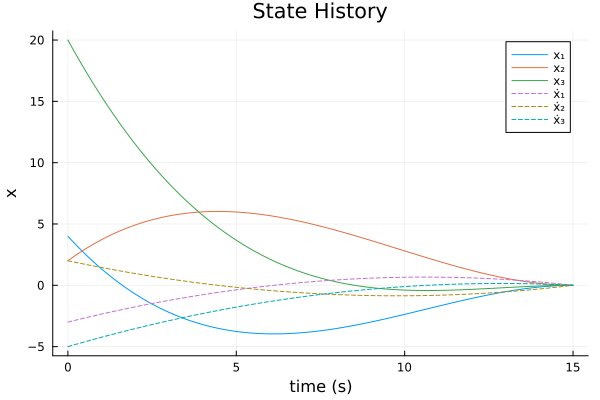

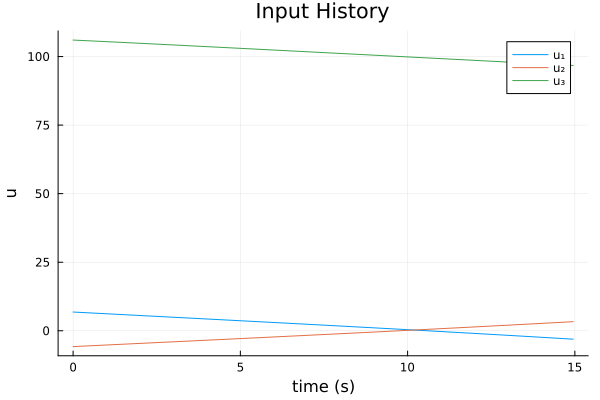

In [571]:
# Let's solve

nx = 6
nu = 3
N = 301
dt = 0.05
t_vec = dt*(0:N-1)
x0 = [4, 2, 20, -3, 2, -5.0]
xg = [0,0,0,0,0,0.0]
Xref = [deepcopy(xg) for i = 1:N]
Uref = [zeros(nu) for i = 1:N-1]

Q = 1e-2*Diagonal([1,1,1,1.0,1,1])
R = 1e-0*Diagonal([1,1,1])
Qf = 100*Q

# ground_level = 0.0
gravity = [0; 0; -9.81]
mass = 10.0
# ωPlanet = [0.0; 0.0; 0.0]
perWeightMax = 2.0
θ_thrust_max = 5.0  # deg
# θ_glideslope = 60.0 # deg
# glide_recover_k = 8

A_cone = [1 0 0; 0 1 0]
c_cone = [0.0, 0.0, tand(θ_thrust_max)]
u_bnd = mass * abs(gravity[3]) * perWeightMax
u_min = -170*ones(nu)
u_max =  170*ones(nu)

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 1
ncu_cone = nu*1; 
cone_scale = 1  # very fragile for each problem

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = N,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

# previous iterate
X = [deepcopy(x0) for i = 1:N]
U = [-mass * gravity for k = 1:N-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
p = [zeros(nx) for i = 1:N]      # cost to go linear term
d = [zeros(nu) for i = 1:N-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:N-1] # feedback gain
Xhist = mpc(params,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 11,verbose = true,ρ = 1e0, ϕ = 10.0);
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end
Xsim_m = mat_from_vec(Xn)
Usim_m = mat_from_vec(Un)
using Plots
display(plot(t_vec,Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"],linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-1],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))

For TrajOpt, it needs more tricks to get better results:
- Hessian of the projection => better approximation
- Scaling between conic constraints and other ones
- Solution polishing

In [569]:
# Check conic violation
convio = 0.0
for k = 1:N-1
    Uc = cone_u(params, U[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end
Xref .= Xn;
Uref .= Un;

-0.21689467346765134

-0.2589880356852845

-0.3010769286798691

-0.34316139948623636

-0.38524149461936474

-0.4273172600734707

-0.4693887413210458

-0.511455983311734

-0.5535190304711648

-0.5955779266996704

-0.6376327153709358

-0.6796834393304803

-0.7217301408940955

-0.7637728618461797

-0.8058116434378313

-0.8478465263850161

-0.8898775508664425

-0.9319047565214049

-0.973928182447457

-1.0159478671979087

-1.057963848779245

-1.099976164648389

-1.1419848517097275

-1.1839899463120567

-1.2259914842453101

-1.2679895007371504

-1.3099840304493293

-1.3519751074738977

-1.393962765329178

-1.435947036955544

-1.4779279547110304

-1.519905550366623

-1.5618798551014246

-1.6038508994974512

-1.6458187135343296

-1.687783326583581

-1.7297447674027007

-1.7717030641290092

-1.813658244273043

-1.8556103347118222

-1.8975593616816555

-1.939505350770669

-1.9814483269109644

-2.0233883143704166

-2.0653253367440856

-2.1072594169452294

-2.1491905771958937

-2.1911188390170615

-2.233044223218335

-2.274966749887203

-2.3168864383776997

-2.3588033072986603

-2.400717374501344

-2.442628657066514

-2.4845371712909543

-2.5264429326733024

-2.5683459558992707

-2.6102462548261665

-2.652143842466689

-2.6940387309720153

-2.735930931614015

-2.7778204547667187

-2.8197073098868835

-2.8615915054936476

-2.903473049147234

-2.9453519474266496

-2.98722820590634

-3.029101829131702

-3.0709728205934796

-3.1128411827009046

-3.1547069167535478

-3.19657002291183

-3.238430500166091

-3.28028834630416

-3.3221435578773395

-3.363996130164737

-3.4058460571357845

-3.447693331410955

-3.489537944220519

-3.5313798853611535

-3.5732191431504567

-3.6150557043791114

-3.6568895542605793

-3.6987206763782607

-3.740549052629884

-3.7823746631690103

-3.8241974863434587

-3.866017498630514

-3.907834674568636

-3.9496489866855553

-3.9914604054224787

-4.033268899054169

-4.075074433604632

-4.116876972758184

-4.158676477765554

-4.200472907344709

-4.242266217576089

-4.284056361791861

-4.325843290458789

-4.367626951054372

-4.409407287935674

-4.451184242200396

-4.492957751539794

-4.53472775008262

-4.576494168229668

-4.618256932478221

-4.66001596523559

-4.701771184621036

-4.743522504255267

-4.785269833036447

-4.827013074901925

-4.868752128574405

-4.910486887291519

-4.952217238517442

-4.993943063635264

-5.035664237618468

-5.077380628679942

-5.11909209789677

-5.160798498808711

-5.2024996769883085

-5.24419546958022

-5.285885704807285

-5.327570201440269

-5.369248768228485

-5.410921203287632

-5.452587293441171

-5.494246813511072

-5.5358995255534875

-5.577545178034004

-5.619183504937267

-5.660814224804492

-5.702437039692191

-5.744051634044406

-5.785657673470082

-5.827254803416146

-5.868842647725763

-5.910420807070186

-5.951988857241014

-5.993546347288331

-6.0350927974882325

-6.076627697121401

-6.118150502041963

-6.159660632013354

-6.20115746778475

-6.2426403478784245

-6.284108565054184

-6.32556136241274

-6.366997929094371

-6.408417395523395

-6.449818828141897

-6.491201223567852

-6.532563502103574

-6.573904500509158

-6.615222963942718

-6.656517536954035

-6.697786753400502

-6.739029025133099

-6.7802426292753815

-6.821425693889045

-6.862576181784571

-6.903691872193654

-6.944770339970411

-6.985808931928074

-7.02680473984597

-7.067754569594181

-7.108654905717652

-7.149501870692486

-7.1902911779104

-7.231018077253885

-7.271677291887794

-7.3122629445995235

-7.352768471656103

-7.393186521693242

-7.4335088365842905

-7.473726110524936

-7.513827822671604

-7.553802037534277

-7.593635165880149

-7.633311677061902

-7.6728137513276025

-7.712120857646831

-7.751209238704257

-7.790051279720385

-7.828614731350523

-7.8668617487138635

-7.904747698192557

-7.9422196705894486

-7.979214623235683

-8.0156570547753

-8.051456095637903

-8.086501877660337

-8.120661034945366

-8.15377119937068

-8.185634416012135

-8.21600956568817

-8.244604224550505

-8.271067027956166

-8.294982655825203

-8.315873032897349

-8.333209897496989

-8.34644446572567

-8.355057567840275

-8.358626542090894

-8.356894369855198

-8.349818352074795

-8.337578680959965

-8.32054317265291

-8.299203011606812

-8.274102721374646

-8.24578275467263

-8.214742261603718

-8.181420726219272

-8.146193164409993

-8.109373310803988

-8.071220587152498

-8.031948223183175

-7.991731121283914

-7.950712836936012

-7.909011485497514

-7.866724604463975

-7.8239330925153086

-7.780704372760137

-7.737094922491717

-7.693152294170481

-7.6489167315632685

-7.604422465216956

-7.559698754328853

-7.514770727942728

-7.4696600670444555

-7.424385560152816

-7.378963557967048

-7.333408347149211

-7.28773245905175

-7.241946925880917

-7.196061494199451

-7.150084803652142

-7.1040245372151265

-7.057887548027048

-7.011679966878896

-6.9654072936631355

-6.919074475465163

-6.872685973487362

-6.826245820600985

-6.779757671003212

-6.73322484320002

-6.68665035732676

-6.640036967649118

-6.59338719094804

-6.546703331378496

-6.499987502298374

-6.453241645485904

-6.406467548100277

-6.3596668576862205

-6.31284109547892

-6.265991668228104

-6.219119878728847

-6.17222693522022

-6.125313959790244

-6.078381995907044

-6.031432015179762

-5.984464923439123

-5.937481566215743

-5.8904827336844505

-5.84346916513403

-5.79644155301435

-5.74940054660685

-5.702346755358258

-5.655280751913077

-5.608203074875899

-5.561114231331194

-5.514014699145015

-5.466904929070187

-5.419785346674313

-5.372656354107633

-5.32551833172611

-5.278371639583302

-5.231216618803192

-5.1840535928449505

-5.136882868669456

-5.08970473781619

-5.04251947739866

-4.9953273510252565

-4.9481286096521275

-4.900923492373703

-4.853712227156324

-4.806495031519522

-4.759272113169404

-4.712043670587859

-4.664809893581376

-4.617570963792531

-4.5703270551769855

-4.523078334449028

-4.475824961497628

-4.4285670897756075

-4.381304866663855

-4.334038433812234

-4.286767927459302

-4.239493478732029

-4.192215213926877

-4.144933254729046

In [529]:
### MPC style ###
Nsim = 121
Nh = 30
t_vec = dt*(0:Nsim-1)

# x0 = [4, 2, 20, -3, 2, -5.0]  # initial plan
x0 = [5, 2, 21, -3, 2, -5.0]  # change this!
# x0 = [5, 3, 21, -3, 2, -5.0]

xg = [0,0,0,0,0,0.0]
Q = 10e-1*Diagonal([1,1,1,1.0,1,1])  # make this higher!
R = 1e-1*Diagonal([1,1,1])
Qf = 1000*Q  # change this!
θ_thrust_max = 12.0  # increase max thrust from plan!

# state is x y v θ
x_min = [-5,-5,0,-10,-10,-10.0]
x_max = [5,5,20,10,10,10.0]

ncx = 2*nx*0
ncu = 2*nu*0
ncg = 0
ncu_cone = nu*1; 
cone_scale = 1

params = (
    nx = nx,
    nu = nu,
    ncx = ncx,
    ncu = ncu,
    ncg = ncg,
    ncu_cone = ncu_cone,
    A_cone = A_cone,
    c_cone = c_cone,
    N = Nh,
    Q = Q,
    R = R,
    Qf = Qf,
    u_min = u_min,
    u_max = u_max,
    x_min = x_min,
    x_max = x_max,
    Xref = Xref,
    Uref = Uref,
    dt = dt,
    mc = 1.0,
    mp = 0.2,
    l = 0.5,
    g = 9.81,
);

Xhist = [deepcopy(x0) for i = 1:Nsim]
Uhist = [-mass * gravity for k = 1:Nsim-1]
# previous iterate
X = [deepcopy(x0) for i = 1:Nh]
U = [-mass * gravity for k = 1:Nh-1]

# new iterate
Xn = deepcopy(X)
Un = deepcopy(U)

P = [zeros(nx,nx) for i = 1:Nh]   # cost to go quadratic term
p = [zeros(nx) for i = 1:Nh]      # cost to go linear term
d = [zeros(nu) for i = 1:Nh-1]    # feedforward control
K = [zeros(nu,nx) for i = 1:Nh-1] # feedback gain

for i = 1:Nsim-Nh-1
    params1 = (; params..., Uref = Uref[i:Nh+i], Xref = Xref[i:Nh+i-1])  # update ref
    X[1] .= Xhist[i]  # update initial
    X_ = mpc(params1,X,U,P,p,K,d,Xn,Un;atol=1e-1,max_iters = 10,verbose = false,ρ = 1e0, ϕ = 10.0);
    Uhist[i] = Un[1]
    Xhist[i+1] = discrete_dynamics(params1,Xhist[i],Uhist[i],i)  # dynamics
end

In [530]:
# Check conic violation
convio = 0.0
for k = 1:Nsim-1
    Uc = cone_u(params, Uhist[k])
    huc = norm(Uc[1:2]) - Uc[3]
    convio = norm(huc + abs.(huc),Inf)
    display(huc) # should <= 0
end

-3.2570264165387

-3.711490720946811

-3.4187386855417223

-2.770937337451185

-3.0867028533431036

-3.038481948924211

-3.350415407718147

-3.2734363081478683

-3.1422120650301046

-11.881028147624225

-1.6823761297294464

-1.090071049080894

-1.9386285080273744

-1.2807684429827972

-1.9500996648089064

-1.4944320243890221

-1.4553930848150074

-1.112339627273883

-12.94411653013822

-1.2729755388941832

-0.9484424154339983

-1.336789134840398

-0.9395977072271897

-12.025683527583105

-6.439518381303181

-17.86187286693272

-0.10218657224889527

-0.5208713920448389

-0.005390127086542407

-0.003239218838541387

-0.10032423665729007

-0.0056010260092850895

-0.005648649425307517

13.431583128826446

-0.005286948979511992

-0.03296646693265204

11.4717553437584

10.009739276477735

-0.008985142662384149

8.232085678288419

-0.009434830595929533

-2.7403989682864562

-0.008964496523690357

16.728934696088622

-0.008842852487441988

14.116550760153626

-0.005843483293306223

-0.006757943839686337

-0.007131379529803916

-0.006430430598660775

-0.014705639164226625

-0.015331220905685294

-0.014171623583820292

-0.009318772095395556

-0.008077014307417363

75.33385400453818

-0.008477784468068128

-0.0067697528040178145

67.11841258232988

-0.00842344355780128

-0.004981513188391153

-0.006701680597498403

62.61175316180871

-0.013143287008482218

-0.01745456277505042

-0.009143333957941414

-0.011144203581030965

-0.011245704448434538

-0.015405209082246074

-0.012561760696034596

-0.011718469124198827

-0.015156671103072838

127.16738852535981

-0.011861170307088331

-0.009816975013567736

-0.008224933869163453

-0.008543208098368813

-0.006120725496378349

-0.018346639065029535

-0.013967212824283592

-0.01398387635100562

-0.023088942283564506

-0.019506684957096176

-0.016650724835370667

-0.011322347634190932

-0.022367153429854625

-0.010153785339848485

220.6084749045641

-0.021664476556210843

-0.01472218875511866

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

-17.29767680750042

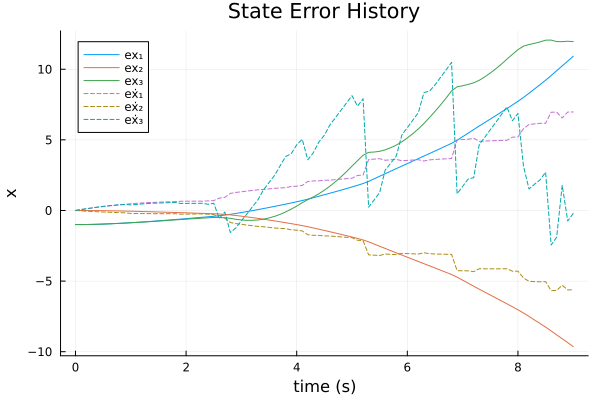

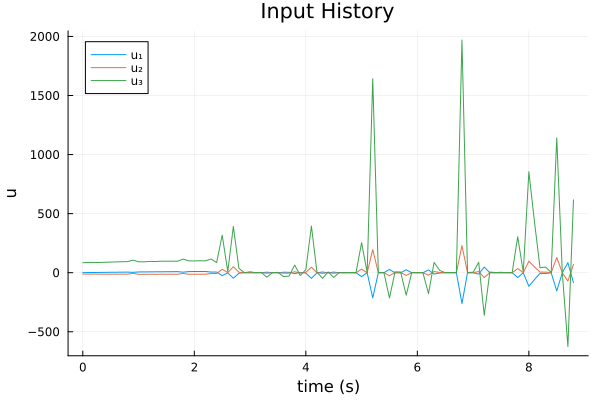

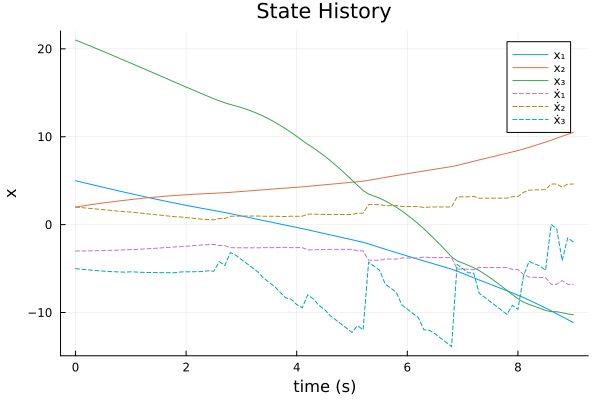

In [531]:
Xsim_m = mat_from_vec(Xhist[1:end-Nh])
Usim_m = mat_from_vec(Uhist[1:end-Nh-1])
e_sim_m = mat_from_vec(Xref[1:end-Nh]-Xhist[1:end-Nh])
display(plot(t_vec[1:end-Nh],e_sim_m',label = ["ex₁" "ex₂" "ex₃" "eẋ₁" "eẋ₂" "eẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State Error History",
             xlabel = "time (s)", ylabel = "x"))
display(plot(t_vec[1:end-Nh-2],Usim_m',label = ["u₁" "u₂" "u₃"],
             title = "Input History",
             xlabel = "time (s)", ylabel = "u"))
display(plot(t_vec[1:end-Nh],Xsim_m',label = ["x₁" "x₂" "x₃" "ẋ₁" "ẋ₂" "ẋ₃"], linestyle=[:solid :solid :solid :dash :dash :dash],
             title = "State History",
             xlabel = "time (s)", ylabel = "x"))